In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('car_data.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import(mean_squared_error,mean_absolute_error,r2_score)
from scipy import stats
import timeit

sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


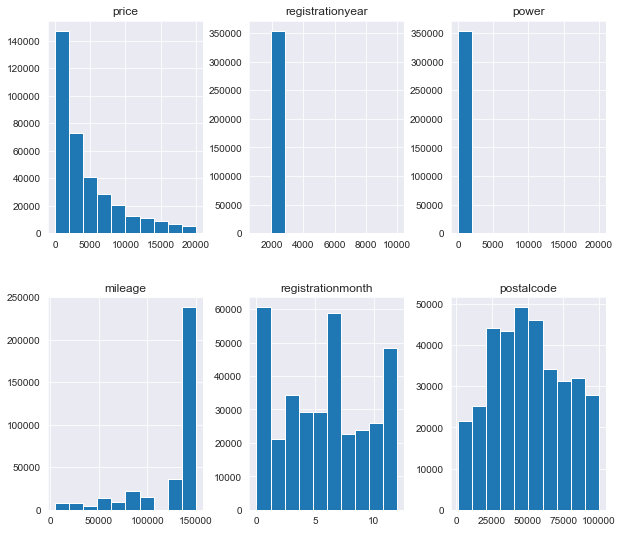

In [7]:
numbers = df.select_dtypes(include = np.number)
list_number = numbers.columns.to_list()
list_number.pop(-2)

numbers[list_number].hist(layout = (2,3), figsize = (10,9))
plt.show()

 We can see there is alot of cars with very high mileage. All our registration fall in 2000s and power falls under 5000.
 We can see there alot cars that cost between 0-5000

In [8]:
df = df.drop_duplicates()

In [9]:
(df.isna().sum() / df.shape[0]) *100

datecrawled           0.000000
price                 0.000000
vehicletype          10.585501
registrationyear      0.000000
gearbox               5.600002
power                 0.000000
model                 5.563573
mileage               0.000000
registrationmonth     0.000000
fueltype              9.287871
brand                 0.000000
notrepaired          20.091385
datecreated           0.000000
numberofpictures      0.000000
postalcode            0.000000
lastseen              0.000000
dtype: float64

In [11]:
df['notrepaired'].fillna('no', inplace = True)

Filling missing values with no

In [12]:
for col in['model','vehicletype','fueltype']:
    df[col].fillna('none', inplace = True)

filling in missing values with "none "

In [13]:
df['gearbox'].value_counts()

manual    268034
auto       66243
Name: gearbox, dtype: int64

In [14]:
df['gearbox'].fillna('manual',inplace = True)

Filling in na values with 'manual' because most cars are manual and not auto. 

In [15]:
(df.isna().sum() / df.shape[0]) *100

datecrawled          0.0
price                0.0
vehicletype          0.0
registrationyear     0.0
gearbox              0.0
power                0.0
model                0.0
mileage              0.0
registrationmonth    0.0
fueltype             0.0
brand                0.0
notrepaired          0.0
datecreated          0.0
numberofpictures     0.0
postalcode           0.0
lastseen             0.0
dtype: float64

In [16]:
cols = ['datecreated','postalcode','lastseen','datecrawled','numberofpictures', 'model', 'brand']
df.drop(cols, axis = 1, inplace = True)

In [17]:
df = df[
    (np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)
]

Dropping values that higher then 3 from our zcore

In [18]:
df = pd.get_dummies(df,columns = ['vehicletype','gearbox','fueltype','notrepaired'], drop_first= True)

## Model training

In [19]:
X = df.drop('price',axis = 1)
y = df.price.values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  random_state=12345)

We split the data using train test split 80/20 

In [21]:
#function to print the variable name 
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
#looping over the spilt data to get spilt rows and columns
for part in [X_train, y_train, X_test, y_test]:
    print(namestr(part, globals())[0], part.shape)

X_train (272709, 21)
y_train (272709,)
X_test (68178, 21)
y_test (68178,)


In [22]:
lr = Pipeline([('scale1',StandardScaler()),("LR",LinearRegression())])
rf = Pipeline([('scale2',StandardScaler()),("RF", RandomForestRegressor())])
lgm = Pipeline([('scale3',StandardScaler()),("LGM", LGBMRegressor())])
xb = Pipeline([('scale4',StandardScaler()),("XGR",XGBRegressor())])
cat = Pipeline([('scale5',StandardScaler()),("CAt",CatBoostRegressor(verbose = False))])

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters

In [23]:
lr_model = cross_val_score(lr, X,y, cv=2, scoring = 'neg_root_mean_squared_error' )

In [24]:
rf_model = cross_val_score(rf, X, y, cv=2, scoring = 'neg_root_mean_squared_error')

In [25]:
lgm_model = cross_val_score(lgm, X, y, cv=2, scoring = 'neg_root_mean_squared_error')

In [26]:
xb_model = cross_val_score(xb, X, y, cv=2, scoring = 'neg_root_mean_squared_error')

In [27]:
cat_model = cross_val_score(cat, X, y, cv=2, scoring = 'neg_root_mean_squared_error')

Evaluating a score by cross-validation using neg root mean squared error

In [28]:
dataframe = {"Linear Regression":lr_model.mean()*-1,"Random Forest":rf_model.mean()*-1, "LightGBM":lgm_model.mean()*-1,'XGboost':xb_model.mean()*-1,'CatBoost':cat_model.mean()*-1}
scores = pd.DataFrame(dataframe, index = [0])
scores

,Linear Regression,Random Forest,LightGBM,XGboost,CatBoost
0,2753.058282,1878.844235,1888.012506,1847.584442,1840.984534


Our best model happen to be  CatBoost 

<AxesSubplot:>

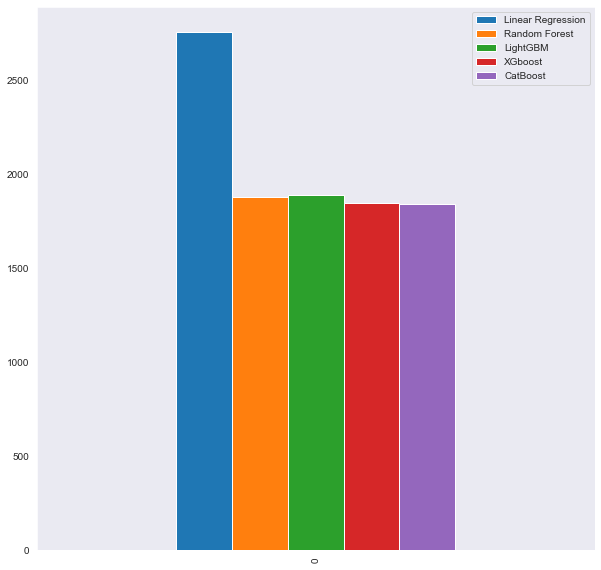

In [29]:
scores.plot(kind = 'bar', figsize = (10,10))

In [30]:
cols = list(X_train.columns)
scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

We standard scale our columns and run our two best models which happen to be Catboost and Xgboost 

In [31]:
start_time = timeit.default_timer()
XG = XGBRegressor(n_jobs =-1)
XG.fit(X_train,y_train)
y_pred =XG.predict(X_test)
elapsed_xg = timeit.default_timer() - start_time

In [32]:

print(f'Mean squared error:{mean_squared_error(y_test,y_pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'R2: {r2_score(y_test,y_pred)}')
print(f'Mean absolute error:{mean_absolute_error(y_test,y_pred)}')

Mean squared error:3375778.80775313
RMSE : 1837.3292594832124
R2: 0.8037045436991115
Mean absolute error:1178.7213563754092


In [33]:
start_time = timeit.default_timer()
cat = CatBoostRegressor(verbose = False)
cat.fit(X_train,y_train)
y_pred = cat.predict(X_test)
elapsed_cat = timeit.default_timer() - start_time

In [34]:
print(f'Mean squared error:{mean_squared_error(y_test,y_pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'R2: {r2_score(y_test,y_pred)}')
print(f'Mean absolute error:{mean_absolute_error(y_test,y_pred)}')

Mean squared error:3366709.7200971656
RMSE : 1834.859591384901
R2: 0.8042318948086011
Mean absolute error:1179.7424697706065


In [35]:
print(f'CatBoost: {elapsed_cat}')
print(f'XGBoost: {elapsed_xg}')

CatBoost: 29.899940300000026
XGBoost: 11.719789799999944


In [36]:
df_pred=pd.DataFrame({'actuals': y_test, 'predictions': y_pred})

<AxesSubplot:title={'center':'Actual vs Predictions'}, xlabel='actuals', ylabel='predictions'>

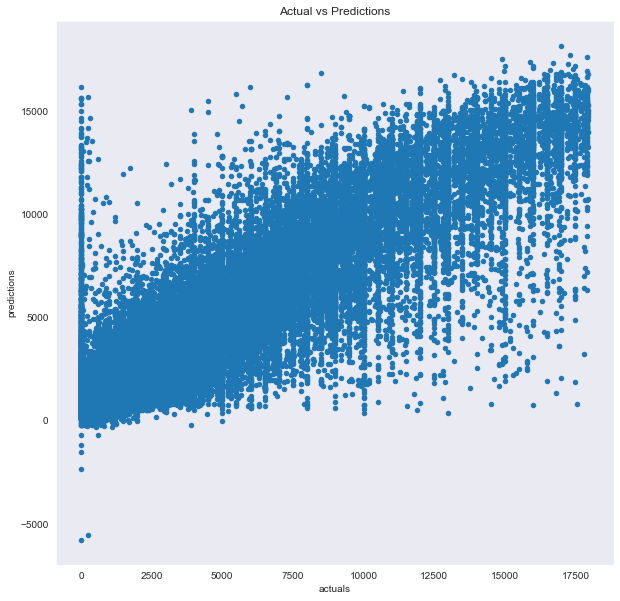

In [37]:

df_pred.plot(title = 'Actual vs Predictions',
            kind ='scatter',x = 'actuals',y = 'predictions', figsize = (10,10))

We can see there is a strong correlation between our actual and predicted values 

Text(0.5, 1.0, 'Feature Importance')

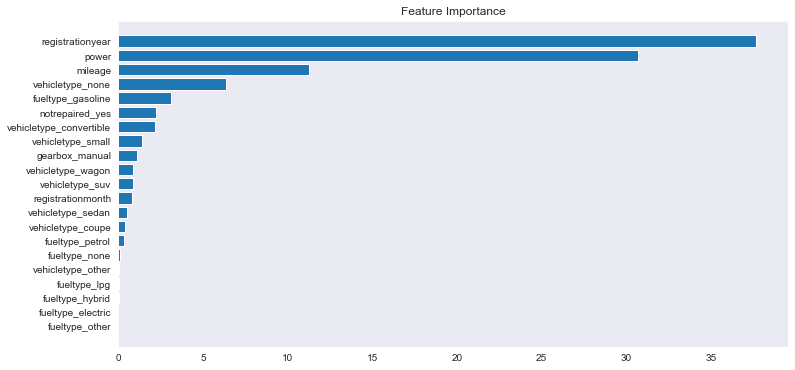

In [39]:
feature_importance = XG.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

## Conclusion 

In this project our goal was to analyze different and check the quality of the prediction,
the speed of the prediction, and the time required for training.
We preprocessed our data checked our distribution and removed outliers We ran 5 models with 3 different gradient models. We scored the models based on there RMSE which is a metric that tells us the average distance between the predicted values from the model and the actual values in the dataset.
We used piplinese while we cross validated our score so there wouldnt be any data leakages.
CatBoost and XGboost had the RMSE and I retrain those two models XGBOOST was faster then Catboost by 10 tens seconds.
Some of the strongest columns are shown above With registration year, power, and brand being our top important columns. 